In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os, glob, inspect, sys
from sksurv.nonparametric import kaplan_meier_estimator
from sksurv.linear_model import CoxPHSurvivalAnalysis

from lifelines.plotting import plot_lifetimes


In [4]:
data = pd.read_csv(os.path.join(os.path.dirname(os.getcwd()), '../Data/Merged_data/Survival_df.csv'),
                  index_col=0)

In [23]:
data_GAN = pd.read_csv(os.path.join(os.path.dirname(os.getcwd()), '../Data/Merged_data/CopulaGAN_simulated_data_survival.csv'),
                  index_col=None)

In [24]:
data_x = data.iloc[:, 2:]
data_y = data.iloc[:, 0:2]

In [25]:
data_GAN_x = data_GAN.iloc[:, 2:]
data_GAN_y = data_GAN.iloc[:, 0:2]

## Lifetime

### Actual

Text(0.5, 1.0, 'Failure at $cycle=1e6$')

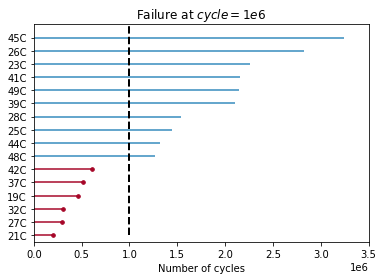

In [19]:
current_time = 1000000

observed_lifetimes = np.minimum(data['F_Time'], current_time)
death_observed = data['F_Time'] < current_time

ax = plot_lifetimes(data['F_Time'], event_observed=death_observed)

ax.set_xlim(0, 3500000)
ax.vlines(1000000, 0, 30, lw=2, linestyles='--')
ax.set_xlabel("Number of cycles")
ax.set_title("Failure at $cycle=1e6$")

## Kaplan Meier

### Actual

Text(0.5, 0, 'time $t$')

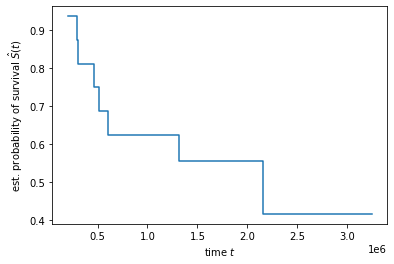

In [174]:
time, survival_prob = kaplan_meier_estimator(data_y["Observed"], data_y["F_Time"])
plt.step(time, survival_prob, where="post")
plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")

### Synthetic

Text(0.5, 0, 'time $t$')

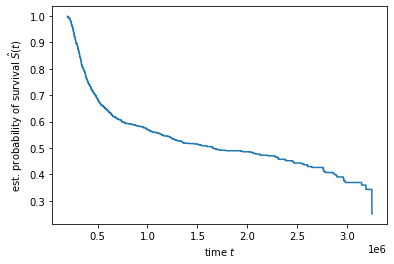

In [32]:
time, survival_prob = kaplan_meier_estimator(data_GAN_y["Observed"], data_GAN_y["F_Time"])
plt.step(time, survival_prob, where="post")
plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")

## Kaplan Meier by 'age' i.e. cycle at NDE

### Actual

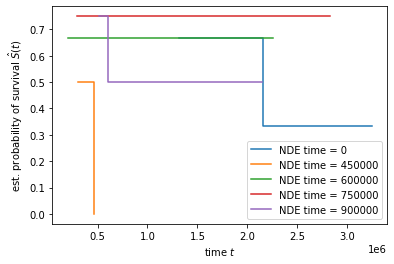

In [176]:
for age in [0, 450000, 600000, 750000, 900000]:
    mask_treat = data_x["NDE_cycle"] == age
    time_age, survival_prob_age = kaplan_meier_estimator(
        data_y["Observed"][mask_treat],
        data_y["F_Time"][mask_treat])

    plt.step(time_age, survival_prob_age, where="post",
             label="NDE time = %s" % age)

plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")
plt.legend(loc="best")

### Synthetic

In [37]:
data_GAN_x

,NDE_cyle,diff_two_peaks_ratio,amp_ratio,pos_ratio,energy_ratio,NLE_ratio_51_17,NLE_ratio_85_17,NLE_ratio_119_17,NLO_avg,Avg_RP,ACEE_30_Avg_58,ACEE_500_Avg_58,ACPD_Avg_58
0,600000,0.529909,1.091504,0.993960,0.848464,0.917375,1.112056,0.505540,5.432829,174.266786,-0.847639,-1.340496,3.276437
1,750000,0.196585,0.849821,0.994489,0.505600,0.910996,1.116821,0.497770,6.898934,171.325300,-0.893297,-1.712179,3.106521
2,900000,0.384845,1.077153,1.000971,0.708655,0.878908,1.130553,0.487624,3.948716,170.217690,-0.764145,-1.190668,2.559568
3,0,2.474125,1.338242,0.995126,1.308626,0.895148,1.132818,0.487866,6.884989,188.904421,-0.476904,-2.805754,4.676679
4,900000,0.437564,1.039553,1.007743,0.721039,0.894121,1.163510,0.495600,5.466000,171.473636,-0.947583,-1.325563,2.553673
...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0,3.131660,1.327767,1.006446,2.672155,0.870106,1.126553,0.461652,5.341247,198.007746,-0.318230,-2.101181,4.278491
996,900000,0.312099,1.255932,0.997464,0.679803,0.887969,1.112964,0.491979,4.663054,171.740833,-0.806248,-1.186281,2.851250
997,900000,0.595612,1.167238,1.000232,0.856687,0.891326,1.148279,0.491675,4.363576,172.275905,-0.880523,-1.327719,3.104035
998,450000,1.486775,1.269441,0.996086,1.009475,0.912585,1.178257,0.488794,4.098630,170.058396,-0.918933,-1.237451,3.339072


In [36]:
data_GAN_x["NDE_cycle"] == 0

KeyError: 'NDE_cycle'

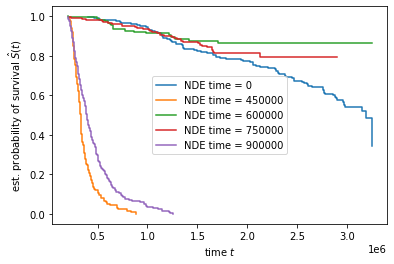

In [38]:
for age in [0, 450000, 600000, 750000, 900000]:
    mask_treat = data_GAN_x["NDE_cyle"] == age
    time_age, survival_prob_age = kaplan_meier_estimator(
        data_GAN_y["Observed"][mask_treat],
        data_GAN_y["F_Time"][mask_treat])

    plt.step(time_age, survival_prob_age, where="post",
             label="NDE time = %s" % age)

plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")
plt.legend(loc="best")

## Structured array for Cox

In [177]:
data_y_num = data_y.to_records(index=False)

## Cox survival analysis

In [178]:
estimator = CoxPHSurvivalAnalysis(alpha=0.0000001, verbose=2)
estimator.fit(data_x, data_y_num)

iter      1: loss = 0.2735597685
iter      2: loss = 0.1125178944
iter      3: loss = 0.0492022581
iter      4: loss = 0.0228681056
iter      5: loss = 0.3838228071
iter      4: loss increased, performing step-halving. loss = 0.0329107245
iter      6: loss = 0.0149345735
iter      7: loss = 0.0079678768
iter      8: loss = 0.0058380946
iter      9: loss = 0.0051705976
iter     10: loss = 0.0048391636
iter     11: loss = 0.0046300913
iter     12: loss = 0.0044254426
iter     13: loss = 11.0045282263
iter     12: loss increased, performing step-halving. loss = 0.0045029132
iter     14: loss = 0.5911439889
iter     13: loss increased, performing step-halving. loss = 0.0045593698
iter     15: loss = 0.0042865617
iter     16: loss = 0.0042254501
iter     17: loss = 0.0041896559
iter     18: loss = 0.0041810043
iter     19: loss = 0.0041798652
iter     20: loss = 0.0041798270
iter     21: loss = 0.0041798269
iter     22: loss = 0.0041798269
iter     22: optimization converged


/home/marie-anne/anaconda3/envs/EPRI/lib/python3.8/site-packages/sksurv/linear_model/coxph.py:425: LinAlgWarning: Ill-conditioned matrix (rcond=4.66688e-17): result may not be accurate.
  delta = solve(optimizer.hessian, optimizer.gradient,
/home/marie-anne/anaconda3/envs/EPRI/lib/python3.8/site-packages/sksurv/linear_model/coxph.py:425: LinAlgWarning: Ill-conditioned matrix (rcond=7.93774e-18): result may not be accurate.
  delta = solve(optimizer.hessian, optimizer.gradient,
/home/marie-anne/anaconda3/envs/EPRI/lib/python3.8/site-packages/sksurv/linear_model/coxph.py:425: LinAlgWarning: Ill-conditioned matrix (rcond=3.88442e-18): result may not be accurate.
  delta = solve(optimizer.hessian, optimizer.gradient,
/home/marie-anne/anaconda3/envs/EPRI/lib/python3.8/site-packages/sksurv/linear_model/coxph.py:425: LinAlgWarning: Ill-conditioned matrix (rcond=2.09751e-18): result may not be accurate.
  delta = solve(optimizer.hessian, optimizer.gradient,
/home/marie-anne/anaconda3/envs/EPRI

CoxPHSurvivalAnalysis(alpha=1e-07, verbose=2)